# Unsupervised learning - Sign Language Clustering

## The dataset:
The [American Sign Language letter database](https://www.kaggle.com/datamunge/sign-language-mnist) of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. 

## Kernal Content:
1. Import libraries and load the dataset
2. Data preprocessing
    * Data scaling
    * Dimentionality reduction
3. Visualization with PCA, TSNE, UMAP and LDA
4. Building Clustering models

    
### 1. Import libraries and load the dataset:

In [17]:
# Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from umap import UMAP

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

import imageio
import time

%matplotlib inline
warnings.filterwarnings('ignore')

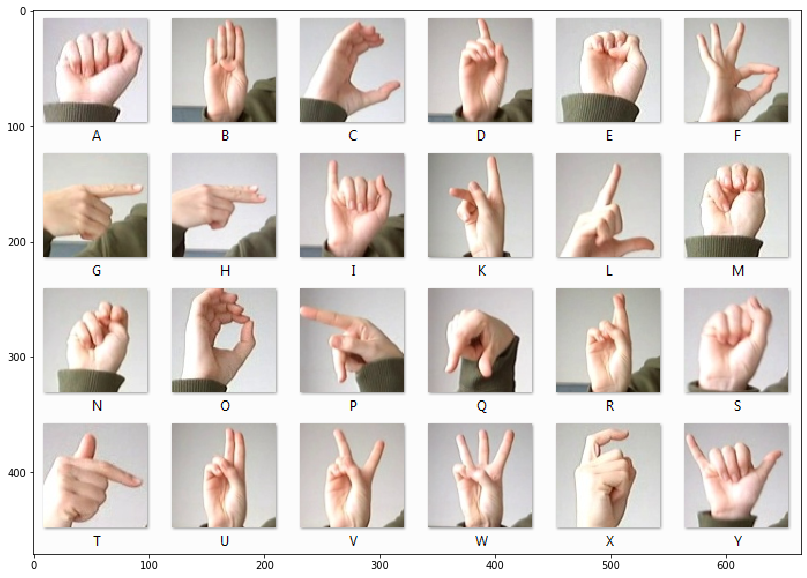

In [2]:
# Display the sign language pictures:
fig = plt.figure(figsize=(20,10))

image = imageio.imread('amer_sign2.png')
plt.imshow(image)

Above shows the different hand movements associated with each letter in the alphabet. In our dataset, each letter is denoted by a number. Our goal is to build a machine learning algorithm that would looks at each picture of hand gesture and classify what letter is associated with it. 

First of all, let's load the dataset and take a look at it:

In [3]:
# Load the dataset:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

print(train.shape)
print(test.shape)

(27455, 785)
(7172, 785)


In [4]:
# Print out the head of the dataset:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Text(0.5, 1.0, 'Count of letter label')

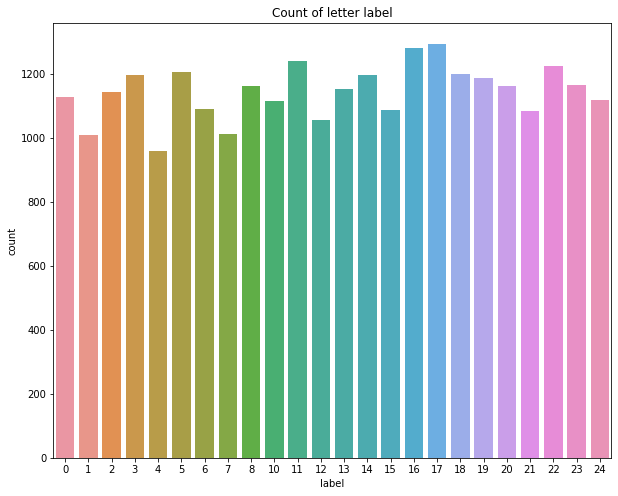

In [5]:
# Total number of letters in the label:
plt.figure(figsize=(10,8))

sns.countplot(train['label'])
plt.title('Count of letter label')

The chart above shows there are 24 letters in our target variables, and count of each letter in our dataset. It looks like there are letters that appear more often than others, but not significant enough for us to worry about class imbalance.

### 2. Data preprocessing

In [6]:
# Split the labels from the dataset:
X_train = train.drop(['label'], axis=1)
y_train = train['label']

X_test = test.drop(['label'], axis=1)
y_test = test['label']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27455, 784) (27455,)
(7172, 784) (7172,)


In [7]:
# Reshape the dataset to show pictures:
images = X_train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

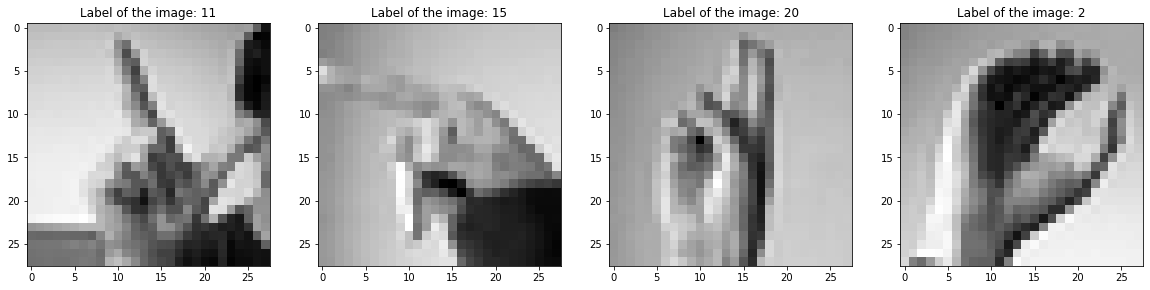

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(images[40].reshape(28,28), cmap='gray')
plt.title('Label of the image: {}'.format(y_train[40]))

plt.subplot(1,4,2)
plt.imshow(images[41].reshape(28,28), cmap='gray')
plt.title('Label of the image: {}'.format(y_train[41]))

plt.subplot(1,4,3)
plt.imshow(images[42].reshape(28,28), cmap='gray')
plt.title('Label of the image: {}'.format(y_train[42]))

plt.subplot(1,4,4)
plt.imshow(images[43].reshape(28,28), cmap='gray')
plt.title('Label of the image: {}'.format(y_train[43]))

plt.show()

In [9]:
# Scale the dataset using StandardScaler:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(27455, 784)
(7172, 784)


In [10]:
# Dimensionality reduction with PCA:
pca = PCA(n_components=120)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(27455, 120)
(7172, 120)


### 3. Visualization using PCA, TSNE, LDA and UMAP

In [11]:
# Visualize the dataset using different dimensionality reduction techniques:
X_train_PCA = PCA(n_components=2).fit_transform(X_train)
X_train_LDA = LDA(n_components=2).fit_transform(X_train,y_train)
X_TSNE = TSNE().fit_transform(X_train)
X_UMAP = umap.UMAP(n_neighbors=15,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_train)

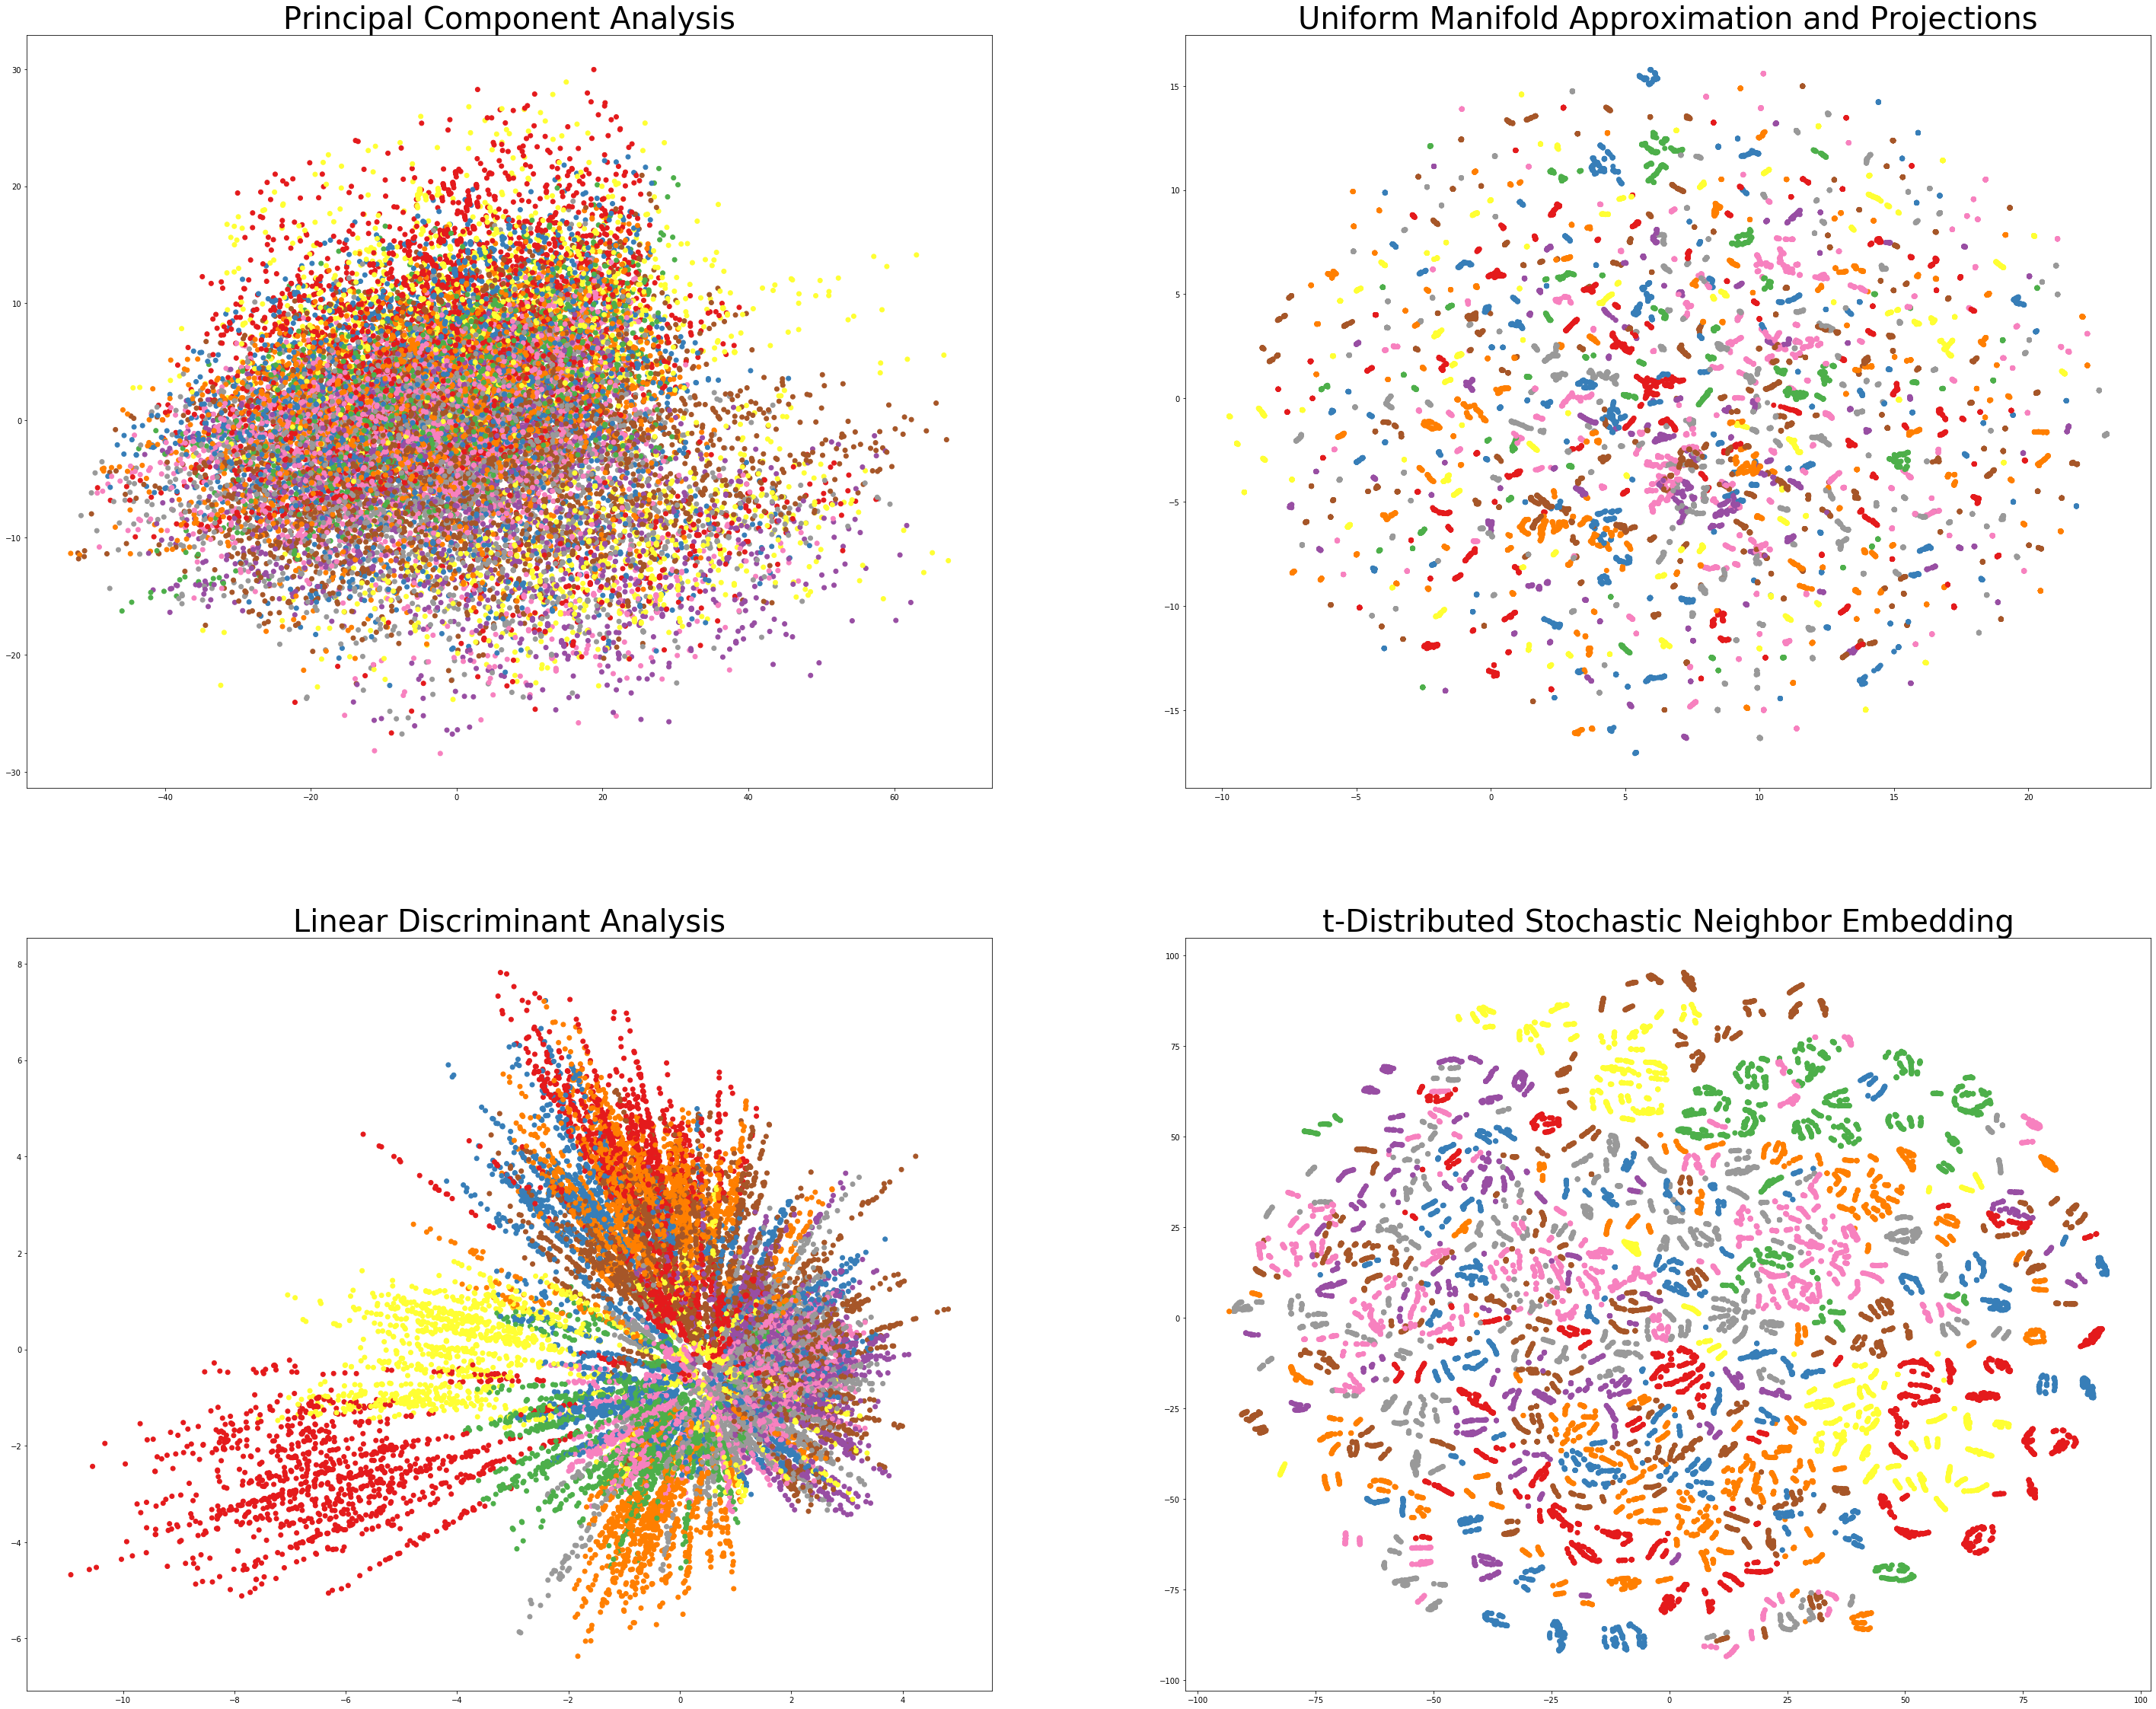

In [12]:
fig = plt.figure(figsize=(50,40))

plt.subplot(2,2,1)
plt.scatter(X_train_PCA[:,0], X_train_PCA[:,1], c=y_train, cmap='Set1')
plt.title("Principal Component Analysis", fontsize=40)

plt.subplot(2,2,2)
plt.scatter(X_UMAP[:,0], X_UMAP[:,1], c=y_train, cmap='Set1')
plt.title("Uniform Manifold Approximation and Projections", fontsize=40)

plt.subplot(2,2,3)
plt.scatter(X_train_LDA[:,0], X_train_LDA[:,1], c=y_train, cmap='Set1')
plt.title("Linear Discriminant Analysis", fontsize=40)

plt.subplot(2,2,4)
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=y_train, cmap='Set1')
plt.title("t-Distributed Stochastic Neighbor Embedding", fontsize=40)

plt.show()

UMAP and TSNE show similar clusters in terms of shape and size, however, it's hard to tell the clusters(different letters) apart just by looking at the visualizations. PCA and Linear Discriminant even give us more of a scattered picture.

### 4. Building clustering models:

In [13]:
# Kmean clustering technique:
k_means = MiniBatchKMeans(n_clusters=24, random_state=123, max_iter=150, batch_size=10)
%timeit k_means.fit(X_train)

y_preds_train = k_means.predict(X_train)
y_preds_test = k_means.predict(X_test)

print('Accuracy of the model in training set is: {:.3f}'.format(accuracy_score(y_train, y_preds_train)))
print('Accuracy of the model in test set is: {:.3f}'.format(accuracy_score(y_test, y_preds_test)))
print('ARI score of the model is: {:.3f}'.format(metrics.adjusted_rand_score(y_test, y_preds_test)))

1.62 s ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy of the model in training set is: 0.058
Accuracy of the model in test set is: 0.067
ARI score of the model is: 0.031


In [14]:
# DBSCAN clustering technique:
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

y_preds_train = dbscan_cluster.fit_predict(X_train)
y_preds_test = dbscan_cluster.fit_predict(X_test)

print('Accuracy of the model in training set is: {:.3f}'.format(accuracy_score(y_train, y_preds_train)))
print('Accuracy of the model in test set is: {:.3f}'.format(accuracy_score(y_test, y_preds_test)))
print('ARI score of the model is: {:.3f}'.format(metrics.adjusted_rand_score(y_test, y_preds_test)))

Accuracy of the model in training set is: 0.000
Accuracy of the model in test set is: 0.002
ARI score of the model is: 0.002


In [15]:
# Gaussian Mixture Models (GMM) clustering technuque
gmm_cluster = GaussianMixture(n_components=24, random_state=123)

%timeit gmm_cluster.fit(X_train)

y_preds_train = gmm_cluster.predict(X_train)
y_preds_test = gmm_cluster.predict(X_test)

print('Accuracy of the model in training set is: {:.3f}'.format(accuracy_score(y_train, y_preds_train)))
print('Accuracy of the model in test set is: {:.3f}'.format(accuracy_score(y_test, y_preds_test)))
print('ARI score of the model is: {:.3f}'.format(metrics.adjusted_rand_score(y_test, y_preds_test)))

35.8 s ± 537 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy of the model in training set is: 0.031
Accuracy of the model in test set is: 0.026
ARI score of the model is: 0.057


In [24]:
# Parameter tunning for Random forest classifier:
param_grid = {'n_estimators':[40, 60, 80, 100, 120], 
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split':[2,3,4]
             }

rfc = RandomForestClassifier()
CV_rfc = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

{'n_estimators': 120, 'min_samples_split': 4, 'max_features': 'sqrt'}


In [26]:
# Random forest classifier:
rfc = RandomForestClassifier(n_estimators=120, min_samples_split=4, max_features='sqrt', random_state=123)

%timeit rfc.fit(X_train, y_train)

y_preds_train = rfc.predict(X_train)
y_preds_test = rfc.predict(X_test)

print('Accuracy of the model in training set is: {:.3f}'.format(accuracy_score(y_train, y_preds_train)))
print('Accuracy of the model in test set is: {:.3f}'.format(accuracy_score(y_test, y_preds_test)))
print('ARI score of the model is: {:.3f}'.format(metrics.adjusted_rand_score(y_test, y_preds_test)))

49.5 s ± 2.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy of the model in training set is: 1.000
Accuracy of the model in test set is: 0.800
ARI score of the model is: 0.691


Out of the 3 clustering techniques(K-means, DBSCAN, and GMM) that we used, K-means gave us the best ARI score. However, all 3 models had terrible accuracy! Finally, I tried Random forest classifier, which is not one of the clustering technique introduced. Even though random forest took the most amount of time to run, the model gave us an accuracy score of 80% and the highest ARI score, which suggests that clustering model might not be the best way to approach this particular sign language dataset.